In [42]:
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
def interpolate_list(lst, target_length=10):
    """Interpolate list to a fixed length using linear interpolation."""
    x_old = np.linspace(0, 1, num=len(lst))
    x_new = np.linspace(0, 1, num=target_length)
    return np.interp(x_new, x_old, lst).tolist()

In [44]:
df_healthy = pd.read_csv("/data.lfpn/ibraun/Code/paper_volume_calculation/Results_Seg_Comparison/Healthy/Healthy_dice_scores.csv")

df_healthy_mean = df_healthy.drop(columns=["BP_dice", "Myo_dice"])

# Convert strings to real Python lists
df_healthy["BP_dice"] = df_healthy["BP_dice"].apply(ast.literal_eval)
df_healthy["Myo_dice"] = df_healthy["Myo_dice"].apply(ast.literal_eval)

# Interpolation function
def interpolate_list(lst, target_length):
    x_old = np.linspace(0, 1, num=len(lst))
    x_new = np.linspace(0, 1, num=target_length)
    return np.interp(x_new, x_old, lst).tolist()

# Find maximum list length
max_len_BP = df_healthy["BP_dice"].apply(len).max()
max_len_Myo = df_healthy["Myo_dice"].apply(len).max()

max_len = np.max([max_len_BP,max_len_Myo])


# Apply interpolation
df_healthy["BP_dice"] = df_healthy["BP_dice"].apply(lambda x: interpolate_list(x, max_len))
df_healthy["Myo_dice"] = df_healthy["Myo_dice"].apply(lambda x: interpolate_list(x, max_len))

lengths = [len(x) for x in df_healthy["BP_dice"]]
print(set(lengths))

df_healthy = df_healthy.drop(columns=["mean_bp_dice", "mean_myo_dice", "std_bp_dice", "std_myo_dice"])

lengths = [len(x) for x in df_healthy["BP_dice"]]
print(set(lengths))
print(df_healthy.head())


{10}
{10}
      Dataset                                            BP_dice  \
0  SCD0003701  [0.965, 0.9614444444444444, 0.954, 0.958, 0.96...   
1  SCD0004001  [0.788, 0.9046666666666666, 0.9473333333333334...   
2  SCD0004101  [0.925, 0.96, 0.932, 0.931, 0.916, 0.927, 0.89...   
3  SCD0004201  [0.963, 0.9536666666666667, 0.9537777777777777...   
4  SCD0004301  [0.762, 0.939, 0.942, 0.956, 0.963, 0.945, 0.9...   

                                            Myo_dice  
0  [0.865, 0.8881111111111111, 0.866111111111111,...  
1  [0.736, 0.8353333333333334, 0.8513333333333334...  
2  [0.766, 0.823, 0.74, 0.75, 0.74, 0.766, 0.805,...  
3  [0.827, 0.8355555555555555, 0.8074444444444444...  
4  [0.756, 0.89, 0.902, 0.922, 0.908, 0.873, 0.93...  


In [45]:
df_healthy = pd.read_csv("/data.lfpn/ibraun/Code/paper_volume_calculation/Results_Seg_Comparison/Healthy/Healthy_dice_scores.csv")

df_healthy_mean = df_healthy.drop(columns=["BP_dice", "Myo_dice"])
df_healthy_mean["Pathology"] = "Healthy"

df_heart_failure_w = pd.read_csv("/data.lfpn/ibraun/Code/paper_volume_calculation/Results_Seg_Comparison/Heart_failure_infarct/Heart_failure_infarct_dice_scores.csv")

df_heart_failure_w_mean = df_heart_failure_w.drop(columns=["BP_dice", "Myo_dice"])
df_heart_failure_w_mean["Pathology"] = "Heart Failure w. Infarct"

df_heart_failure = pd.read_csv("/data.lfpn/ibraun/Code/paper_volume_calculation/Results_Seg_Comparison/Heart_failure/Heart_failure_dice_scores.csv")

df_heart_failure_mean = df_heart_failure.drop(columns=["BP_dice", "Myo_dice"])
df_heart_failure_mean["Pathology"] = "Heart Failure"

df_LV_hypertrophy = pd.read_csv("/data.lfpn/ibraun/Code/paper_volume_calculation/Results_Seg_Comparison/LV_hypertrophy/LV_hypertrophy_dice_scores.csv")

df_LV_hypertrophy_mean = df_LV_hypertrophy.drop(columns=["BP_dice", "Myo_dice"])
df_LV_hypertrophy_mean["Pathology"] = "LV Hypertrophy"

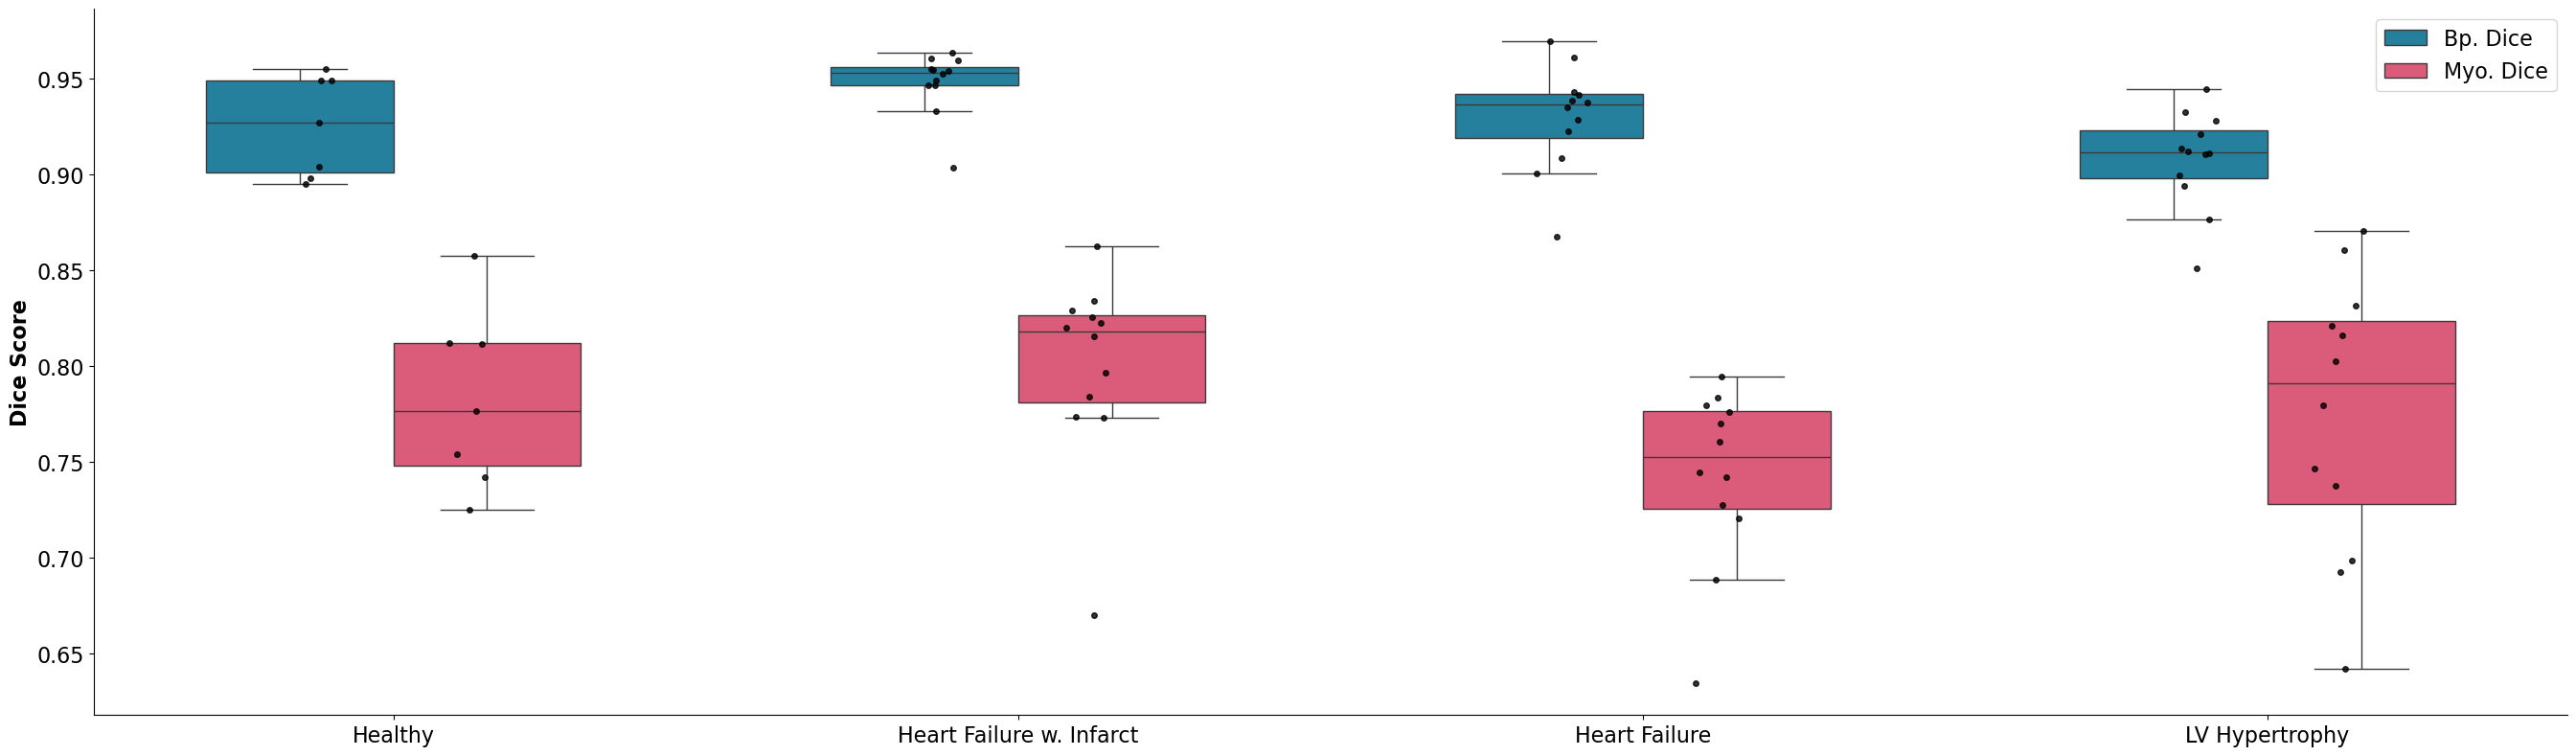

In [46]:

# Combine all pathologies
df_all = pd.concat([df_healthy_mean, df_heart_failure_w_mean, df_heart_failure_mean, df_LV_hypertrophy_mean], ignore_index=True)  # Repeat for all 4 pathologies

# Convert wide -> long format for Seaborn
df_melt = df_all.melt(
    id_vars=["Dataset","Pathology"],
    value_vars=["mean_bp_dice","mean_myo_dice"],
    var_name="Dice_Type",
    value_name="Dice_Score"
)

# Rename dice types for nicer labels
df_melt["Dice_Type"] = df_melt["Dice_Type"].replace({
    "mean_bp_dice": "Bp. Dice",
    "mean_myo_dice": "Myo. Dice"
})
# Modern color palette
colors = {
    'BP': '#118ab2ff',  # blue
    'Myo': '#ef476fff',  # red
    'ground_truth': '#000000'  # points
}
fig, ax = plt.subplots(figsize=(27, 8), dpi=100)

# Create boxplot first
box_plot = sns.boxplot(
    x="Pathology", y="Dice_Score", hue="Dice_Type",
    data=df_melt, palette=[colors['BP'], colors['Myo']],
    width=0.6, ax=ax, linewidth=1, fliersize=0
)

# Semi-transparent boxes
for patch in box_plot.artists:
    patch.set_alpha(0.6)

# Get the positions of the boxes for manual point placement
pathologies = df_melt['Pathology'].unique()
dice_types = df_melt['Dice_Type'].unique()

# Calculate box positions (seaborn uses these internally)
n_pathologies = len(pathologies)
n_dice_types = len(dice_types)
width = 0.6
offset = width / (n_dice_types + 1)

for i, pathology in enumerate(pathologies):
    for j, dice_type in enumerate(dice_types):
        # Calculate x position for each box
        x_pos = i + (j - (n_dice_types-1)/2) * offset * 1.2
        
        # Get data for this combination
        subset = df_melt[(df_melt['Pathology'] == pathology) & 
                        (df_melt['Dice_Type'] == dice_type)]
        
        # Add jitter to x positions
        x_jitter = np.random.normal(0, 0.02, len(subset))
        
        # Plot points
        ax.scatter(x_pos + x_jitter, subset['Dice_Score'], 
                  color='black', alpha=0.8, s=16, zorder=3)

# Remove duplicate legend entries
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:2], labels[0:2], fontsize = 16)

# Labels and styling
ax.set_ylabel("Dice Score", fontsize=16, fontweight='bold', color='#000000')
ax.set_xlabel("", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16, colors='#000000')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#000000')
ax.spines['bottom'].set_color('#000000')

plt.savefig("/data.lfpn/ibraun/Code/paper_volume_calculation/Graphics/seg_manual_auto_dice_score.pdf",dpi=300)
plt.savefig("/data.lfpn/ibraun/Code/paper_volume_calculation/Graphics/seg_manual_auto_dice_score.svg")

plt.tight_layout()
plt.show()

## Healthy Pathology

In [47]:
df_healthy = pd.read_csv("/data.lfpn/ibraun/Code/paper_volume_calculation/Results_Seg_Comparison/Healthy/Healthy_dice_scores.csv")

df_healthy_mean = df_healthy.drop(columns=["BP_dice", "Myo_dice"])

# Convert strings to real Python lists
df_healthy["BP_dice"] = df_healthy["BP_dice"].apply(ast.literal_eval)
df_healthy["Myo_dice"] = df_healthy["Myo_dice"].apply(ast.literal_eval)

# Interpolation function
def interpolate_list(lst, target_length):
    x_old = np.linspace(0, 1, num=len(lst))
    x_new = np.linspace(0, 1, num=target_length)
    return np.interp(x_new, x_old, lst).tolist()

# Find maximum list length
max_len_BP = df_healthy["BP_dice"].apply(len).max()
max_len_Myo = df_healthy["Myo_dice"].apply(len).max()

max_len = np.max([max_len_BP,max_len_Myo])


# Apply interpolation
df_healthy["BP_dice"] = df_healthy["BP_dice"].apply(lambda x: interpolate_list(x, max_len))
df_healthy["Myo_dice"] = df_healthy["Myo_dice"].apply(lambda x: interpolate_list(x, max_len))

df_healthy = df_healthy.drop(columns=["mean_bp_dice", "mean_myo_dice", "std_bp_dice", "std_myo_dice"])


/tmp/ipykernel_852768/431223135.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{abs(x):.2f}" for x in xticks])


<Figure size 640x480 with 0 Axes>

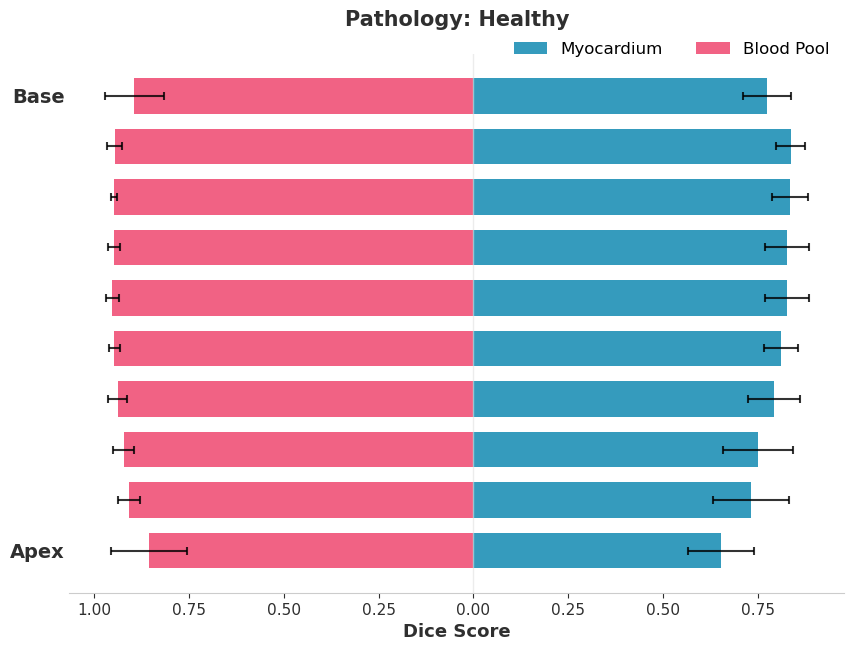

In [48]:

# If lists are stored as strings, convert them
df_healthy["BP_dice"] = df_healthy["BP_dice"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_healthy["Myo_dice"] = df_healthy["Myo_dice"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Convert to numpy arrays
# Make sure each element in the list is a float
bp_matrix = np.array([list(map(float, x)) for x in df_healthy["BP_dice"]])
myo_matrix = np.array([list(map(float, x)) for x in df_healthy["Myo_dice"]])

# Compute mean and std across datasets
bp_mean = bp_matrix.mean(axis=0)
bp_std  = bp_matrix.std(axis=0)

myo_mean = myo_matrix.mean(axis=0)
myo_std  = myo_matrix.std(axis=0)

plt.tight_layout()# --- Professional Population Pyramid Plot with Error Bars ---
import matplotlib.pyplot as plt
import numpy as np

# Set professional style
plt.style.use('default')
fig, ax = plt.subplots(figsize=(10, 7))

# Data positioning
y_positions = np.arange(len(bp_mean))

# Define professional color palette
colors = {
    'myo': '#118ab2ff',    # Original blue
    'bp': '#ef476fff',     # Original red
    'text': '#2F2F2F'      # Dark gray for text
}

# Plot with enhanced styling
# Myocardium (left side)
bars_myo = ax.barh(y_positions, myo_mean, xerr=myo_std, 
                   color=colors['myo'], alpha=0.85, 
                   label="Myocardium", height=0.7,
                   error_kw={'alpha': 0.8, 'capsize': 3, 'capthick': 1.5, 'elinewidth': 1.5})

# Blood Pool (right side, negative values for pyramid effect)
bars_bp = ax.barh(y_positions, -bp_mean, xerr=bp_std, 
                  color=colors['bp'], alpha=0.85, 
                  label="Blood Pool", height=0.7,
                  error_kw={'alpha': 0.8, 'capsize': 3, 'capthick': 1.5, 'elinewidth': 1.5})

# Enhance axes and styling
ax.invert_yaxis()

# Remove all grid lines for clean look
ax.grid(False)

# Enhanced axis labels and ticks
ax.set_yticks([0, len(y_positions)-1])
ax.set_yticklabels(["Base", "Apex"], fontsize=14, fontweight='bold', color=colors['text'])
ax.tick_params(axis='y', length=0)  # Remove y-axis tick marks

# X-axis formatting
ax.set_xlabel("Dice Score", fontsize=13, fontweight='semibold', color=colors['text'])
ax.tick_params(axis='x', labelsize=11, colors=colors['text'])

# Convert x-axis labels to absolute values
xticks = ax.get_xticks()
ax.set_xticklabels([f"{abs(x):.2f}" for x in xticks])

# Professional title
ax.set_title("Pathology: Healthy", 
             fontsize=15, fontweight='bold', pad=20, color=colors['text'])

# Enhanced legend
# Enhanced legend - positioned next to title, no box
legend = ax.legend(bbox_to_anchor=(0.98, 0.98), loc='upper right', frameon=False, 
                   fontsize=12, ncol=2)
# Position legend higher up near the title area
legend.set_bbox_to_anchor((1.0, 1.05))

# Add minimal visual separation at x=0
ax.axvline(x=0, color='#E0E0E0', linestyle='-', linewidth=1, alpha=0.6)


# Fine-tune layout - remove spines for clean look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(0.8)

plt.savefig("/data.lfpn/ibraun/Code/paper_volume_calculation/Graphics/healthy_dice.pdf",dpi=300)
plt.savefig("/data.lfpn/ibraun/Code/paper_volume_calculation/Graphics/healthy_dice.svg")

plt.show()

## Heart Failure with Infarct

In [49]:
df_failure_infarct = pd.read_csv("/data.lfpn/ibraun/Code/paper_volume_calculation/Results_Seg_Comparison/Heart_failure_infarct/Heart_failure_infarct_dice_scores.csv")

df_failure_infarct_mean = df_failure_infarct.drop(columns=["BP_dice", "Myo_dice"])

# Convert strings to real Python lists
df_failure_infarct["BP_dice"] = df_failure_infarct["BP_dice"].apply(ast.literal_eval)
df_failure_infarct["Myo_dice"] = df_failure_infarct["Myo_dice"].apply(ast.literal_eval)

# Interpolation function
def interpolate_list(lst, target_length):
    x_old = np.linspace(0, 1, num=len(lst))
    x_new = np.linspace(0, 1, num=target_length)
    return np.interp(x_new, x_old, lst).tolist()

# Find maximum list length
max_len_BP = df_failure_infarct["BP_dice"].apply(len).max()
max_len_Myo = df_failure_infarct["Myo_dice"].apply(len).max()

max_len = np.max([max_len_BP,max_len_Myo])

# Apply interpolation
df_failure_infarct["BP_dice"] = df_failure_infarct["BP_dice"].apply(lambda x: interpolate_list(x, max_len))
df_failure_infarct["Myo_dice"] = df_failure_infarct["Myo_dice"].apply(lambda x: interpolate_list(x, max_len))

df_failure_infarct = df_failure_infarct.drop(columns=["mean_bp_dice", "mean_myo_dice", "std_bp_dice", "std_myo_dice"])

[0.91, 0.9413846153846154, 0.9614615384615385, 0.9626923076923076, 0.9694615384615385, 0.9745384615384615, 0.9548461538461538, 0.9465384615384614, 0.9496153846153845, 0.9430000000000001, 0.9383846153846154, 0.9439230769230769, 0.8936923076923077, 0.81]


/tmp/ipykernel_852768/4032952396.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{abs(x):.2f}" for x in xticks])


<Figure size 640x480 with 0 Axes>

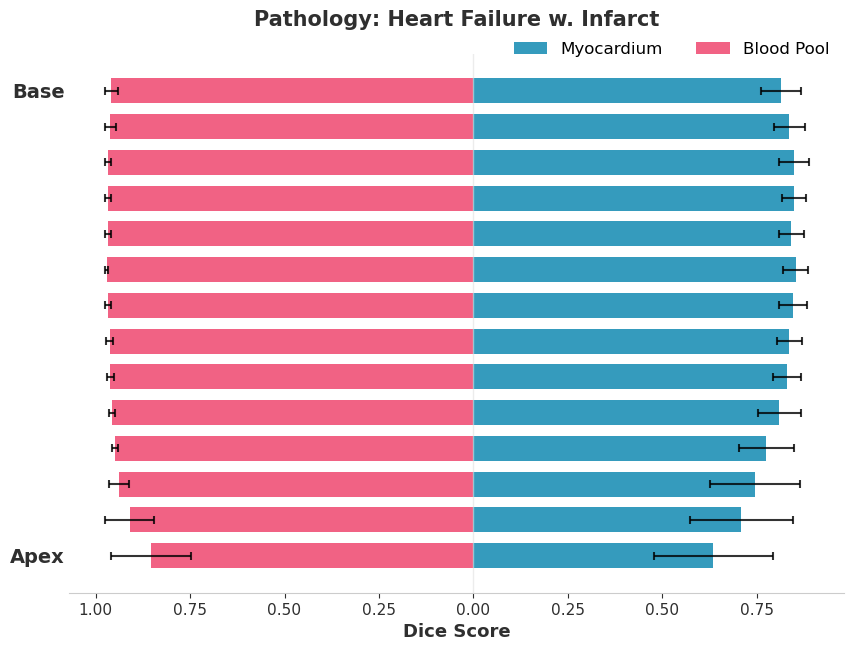

In [50]:

# If lists are stored as strings, convert them
df_failure_infarct["BP_dice"] = df_failure_infarct["BP_dice"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_failure_infarct["Myo_dice"] = df_failure_infarct["Myo_dice"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


print(df_failure_infarct["BP_dice"].iloc[0])

# Convert to numpy arrays
# Make sure each element in the list is a float
bp_matrix = np.array([list(map(float, x)) for x in df_failure_infarct["BP_dice"]])
myo_matrix = np.array([list(map(float, x)) for x in df_failure_infarct["Myo_dice"]])

# Compute mean and std across datasets
bp_mean = bp_matrix.mean(axis=0)
bp_std  = bp_matrix.std(axis=0)

myo_mean = myo_matrix.mean(axis=0)
myo_std  = myo_matrix.std(axis=0)

plt.tight_layout()# --- Professional Population Pyramid Plot with Error Bars ---
import matplotlib.pyplot as plt
import numpy as np

# Set professional style
plt.style.use('default')
fig, ax = plt.subplots(figsize=(10, 7))

# Data positioning
y_positions = np.arange(len(bp_mean))

# Define professional color palette
colors = {
    'myo': '#118ab2ff',    # Original blue
    'bp': '#ef476fff',     # Original red
    'text': '#2F2F2F'      # Dark gray for text
}

# Plot with enhanced styling
# Myocardium (left side)
bars_myo = ax.barh(y_positions, myo_mean, xerr=myo_std, 
                   color=colors['myo'], alpha=0.85, 
                   label="Myocardium", height=0.7,
                   error_kw={'alpha': 0.8, 'capsize': 3, 'capthick': 1.5, 'elinewidth': 1.5})

# Blood Pool (right side, negative values for pyramid effect)
bars_bp = ax.barh(y_positions, -bp_mean, xerr=bp_std, 
                  color=colors['bp'], alpha=0.85, 
                  label="Blood Pool", height=0.7,
                  error_kw={'alpha': 0.8, 'capsize': 3, 'capthick': 1.5, 'elinewidth': 1.5})

# Enhance axes and styling
ax.invert_yaxis()

# Remove all grid lines for clean look
ax.grid(False)

# Enhanced axis labels and ticks
ax.set_yticks([0, len(y_positions)-1])
ax.set_yticklabels(["Base", "Apex"], fontsize=14, fontweight='bold', color=colors['text'])
ax.tick_params(axis='y', length=0)  # Remove y-axis tick marks

# X-axis formatting
ax.set_xlabel("Dice Score", fontsize=13, fontweight='semibold', color=colors['text'])
ax.tick_params(axis='x', labelsize=11, colors=colors['text'])

# Convert x-axis labels to absolute values
xticks = ax.get_xticks()
ax.set_xticklabels([f"{abs(x):.2f}" for x in xticks])

# Professional title
ax.set_title("Pathology: Heart Failure w. Infarct", 
             fontsize=15, fontweight='bold', pad=20, color=colors['text'])

# Enhanced legend
# Enhanced legend - positioned next to title, no box
legend = ax.legend(bbox_to_anchor=(0.98, 0.98), loc='upper right', frameon=False, 
                   fontsize=12, ncol=2)
# Position legend higher up near the title area
legend.set_bbox_to_anchor((1.0, 1.05))

# Add minimal visual separation at x=0
ax.axvline(x=0, color='#E0E0E0', linestyle='-', linewidth=1, alpha=0.6)



# Fine-tune layout - remove spines for clean look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(0.8)

plt.savefig("/data.lfpn/ibraun/Code/paper_volume_calculation/Graphics/heart_failure_infarct_dice.pdf",dpi=300)
plt.savefig("/data.lfpn/ibraun/Code/paper_volume_calculation/Graphics/heart_failure_infacrt_dice.svg")

plt.show()

## Heart Failure no Infarct

In [51]:
df_failure = pd.read_csv("/data.lfpn/ibraun/Code/paper_volume_calculation/Results_Seg_Comparison/Heart_failure/Heart_failure_dice_scores.csv")

df_failure_mean = df_failure.drop(columns=["BP_dice", "Myo_dice"])

# Convert strings to real Python lists
df_failure["BP_dice"] = df_failure["BP_dice"].apply(ast.literal_eval)
df_failure["Myo_dice"] = df_failure["Myo_dice"].apply(ast.literal_eval)

# Interpolation function
def interpolate_list(lst, target_length):
    x_old = np.linspace(0, 1, num=len(lst))
    x_new = np.linspace(0, 1, num=target_length)
    return np.interp(x_new, x_old, lst).tolist()

# Find maximum list length
max_len_BP = df_failure["BP_dice"].apply(len).max()
max_len_Myo = df_failure["Myo_dice"].apply(len).max()

max_len = np.max([max_len_BP,max_len_Myo])


# Apply interpolation
df_failure["BP_dice"] = df_failure["BP_dice"].apply(lambda x: interpolate_list(x, max_len))
df_failure["Myo_dice"] = df_failure["Myo_dice"].apply(lambda x: interpolate_list(x, max_len))

df_failure = df_failure.drop(columns=["mean_bp_dice", "mean_myo_dice", "std_bp_dice", "std_myo_dice"])


/tmp/ipykernel_852768/3347025727.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{abs(x):.2f}" for x in xticks])


<Figure size 640x480 with 0 Axes>

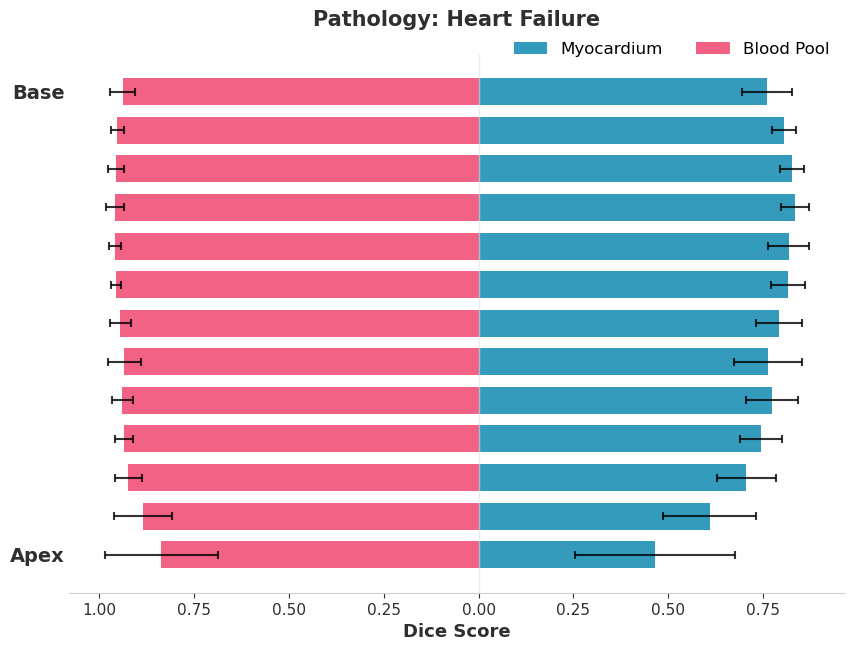

In [52]:

# If lists are stored as strings, convert them
df_failure["BP_dice"] = df_failure["BP_dice"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_failure["Myo_dice"] = df_failure["Myo_dice"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Convert to numpy arrays
# Make sure each element in the list is a float
bp_matrix = np.array([list(map(float, x)) for x in df_failure["BP_dice"]])
myo_matrix = np.array([list(map(float, x)) for x in df_failure["Myo_dice"]])

# Compute mean and std across datasets
bp_mean = bp_matrix.mean(axis=0)
bp_std  = bp_matrix.std(axis=0)

myo_mean = myo_matrix.mean(axis=0)
myo_std  = myo_matrix.std(axis=0)

plt.tight_layout()# --- Professional Population Pyramid Plot with Error Bars ---
import matplotlib.pyplot as plt
import numpy as np

# Set professional style
plt.style.use('default')
fig, ax = plt.subplots(figsize=(10, 7))

# Data positioning
y_positions = np.arange(len(bp_mean))

# Define professional color palette
colors = {
    'myo': '#118ab2ff',    # Original blue
    'bp': '#ef476fff',     # Original red
    'text': '#2F2F2F'      # Dark gray for text
}

# Plot with enhanced styling
# Myocardium (left side)
bars_myo = ax.barh(y_positions, myo_mean, xerr=myo_std, 
                   color=colors['myo'], alpha=0.85, 
                   label="Myocardium", height=0.7,
                   error_kw={'alpha': 0.8, 'capsize': 3, 'capthick': 1.5, 'elinewidth': 1.5})

# Blood Pool (right side, negative values for pyramid effect)
bars_bp = ax.barh(y_positions, -bp_mean, xerr=bp_std, 
                  color=colors['bp'], alpha=0.85, 
                  label="Blood Pool", height=0.7,
                  error_kw={'alpha': 0.8, 'capsize': 3, 'capthick': 1.5, 'elinewidth': 1.5})

# Enhance axes and styling
ax.invert_yaxis()

# Remove all grid lines for clean look
ax.grid(False)

# Enhanced axis labels and ticks
ax.set_yticks([0, len(y_positions)-1])
ax.set_yticklabels(["Base", "Apex"], fontsize=14, fontweight='bold', color=colors['text'])
ax.tick_params(axis='y', length=0)  # Remove y-axis tick marks

# X-axis formatting
ax.set_xlabel("Dice Score", fontsize=13, fontweight='semibold', color=colors['text'])
ax.tick_params(axis='x', labelsize=11, colors=colors['text'])

# Convert x-axis labels to absolute values
xticks = ax.get_xticks()
ax.set_xticklabels([f"{abs(x):.2f}" for x in xticks])

# Professional title
ax.set_title("Pathology: Heart Failure", 
             fontsize=15, fontweight='bold', pad=20, color=colors['text'])

# Enhanced legend
# Enhanced legend - positioned next to title, no box
legend = ax.legend(bbox_to_anchor=(0.98, 0.98), loc='upper right', frameon=False, 
                   fontsize=12, ncol=2)
# Position legend higher up near the title area
legend.set_bbox_to_anchor((1.0, 1.05))

# Add minimal visual separation at x=0
ax.axvline(x=0, color='#E0E0E0', linestyle='-', linewidth=1, alpha=0.6)


# Fine-tune layout - remove spines for clean look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(0.8)

plt.savefig("/data.lfpn/ibraun/Code/paper_volume_calculation/Graphics/heart_failure_dice.pdf",dpi=300)
plt.savefig("/data.lfpn/ibraun/Code/paper_volume_calculation/Graphics/heart_failure_dice.svg")

plt.show()

## LV Hypertropy

In [53]:
df_hyper = pd.read_csv("/data.lfpn/ibraun/Code/paper_volume_calculation/Results_Seg_Comparison/LV_hypertrophy/LV_hypertrophy_dice_scores.csv")

df_hyper_mean = df_hyper.drop(columns=["BP_dice", "Myo_dice"])

# Convert strings to real Python lists
df_hyper["BP_dice"] = df_hyper["BP_dice"].apply(ast.literal_eval)
df_hyper["Myo_dice"] = df_hyper["Myo_dice"].apply(ast.literal_eval)

# Interpolation function
def interpolate_list(lst, target_length):
    x_old = np.linspace(0, 1, num=len(lst))
    x_new = np.linspace(0, 1, num=target_length)
    return np.interp(x_new, x_old, lst).tolist()

# Find maximum list length
max_len_BP = df_hyper["BP_dice"].apply(len).max()
max_len_Myo = df_hyper["Myo_dice"].apply(len).max()

max_len = np.max([max_len_BP,max_len_Myo])

# Apply interpolation
df_hyper["BP_dice"] = df_hyper["BP_dice"].apply(lambda x: interpolate_list(x, max_len))
df_hyper["Myo_dice"] = df_hyper["Myo_dice"].apply(lambda x: interpolate_list(x, max_len))

df_hyper = df_hyper.drop(columns=["mean_bp_dice", "mean_myo_dice", "std_bp_dice", "std_myo_dice"])

/tmp/ipykernel_852768/1047080048.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{abs(x):.2f}" for x in xticks])


<Figure size 640x480 with 0 Axes>

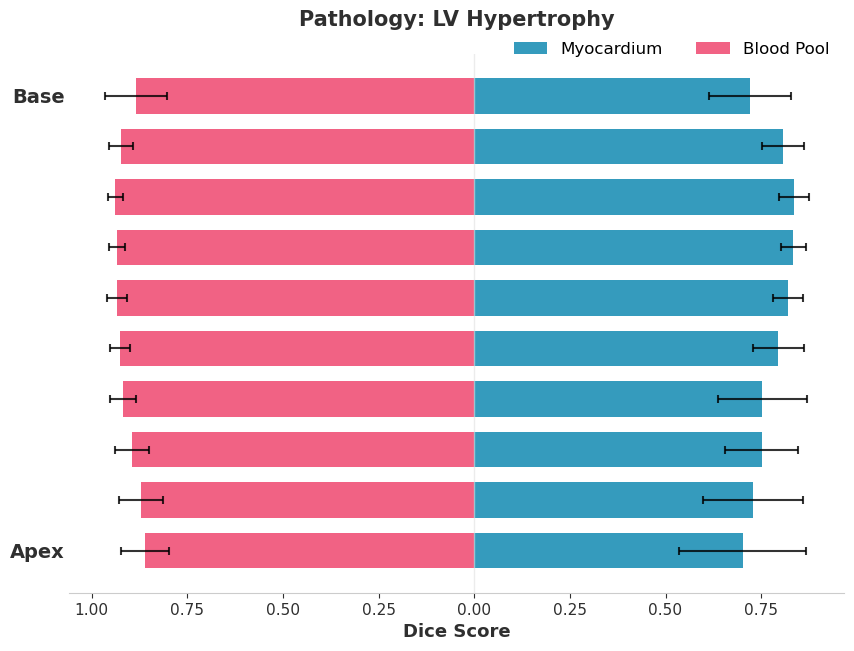

In [54]:

# If lists are stored as strings, convert them
df_hyper["BP_dice"] = df_hyper["BP_dice"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_hyper["Myo_dice"] = df_hyper["Myo_dice"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Convert to numpy arrays
# Make sure each element in the list is a float
bp_matrix = np.array([list(map(float, x)) for x in df_hyper["BP_dice"]])
myo_matrix = np.array([list(map(float, x)) for x in df_hyper["Myo_dice"]])

# Compute mean and std across datasets
bp_mean = bp_matrix.mean(axis=0)
bp_std  = bp_matrix.std(axis=0)

myo_mean = myo_matrix.mean(axis=0)
myo_std  = myo_matrix.std(axis=0)

plt.tight_layout()# --- Professional Population Pyramid Plot with Error Bars ---
import matplotlib.pyplot as plt
import numpy as np

# Set professional style
plt.style.use('default')
fig, ax = plt.subplots(figsize=(10, 7))

# Data positioning
y_positions = np.arange(len(bp_mean))

# Define professional color palette
colors = {
    'myo': '#118ab2ff',    # Original blue
    'bp': '#ef476fff',     # Original red
    'text': '#2F2F2F'      # Dark gray for text
}

# Plot with enhanced styling
# Myocardium (left side)
bars_myo = ax.barh(y_positions, myo_mean, xerr=myo_std, 
                   color=colors['myo'], alpha=0.85, 
                   label="Myocardium", height=0.7,
                   error_kw={'alpha': 0.8, 'capsize': 3, 'capthick': 1.5, 'elinewidth': 1.5})

# Blood Pool (right side, negative values for pyramid effect)
bars_bp = ax.barh(y_positions, -bp_mean, xerr=bp_std, 
                  color=colors['bp'], alpha=0.85, 
                  label="Blood Pool", height=0.7,
                  error_kw={'alpha': 0.8, 'capsize': 3, 'capthick': 1.5, 'elinewidth': 1.5})

# Enhance axes and styling
ax.invert_yaxis()

# Remove all grid lines for clean look
ax.grid(False)

# Enhanced axis labels and ticks
ax.set_yticks([0, len(y_positions)-1])
ax.set_yticklabels(["Base", "Apex"], fontsize=14, fontweight='bold', color=colors['text'])
ax.tick_params(axis='y', length=0)  # Remove y-axis tick marks

# X-axis formatting
ax.set_xlabel("Dice Score", fontsize=13, fontweight='semibold', color=colors['text'])
ax.tick_params(axis='x', labelsize=11, colors=colors['text'])

# Convert x-axis labels to absolute values
xticks = ax.get_xticks()
ax.set_xticklabels([f"{abs(x):.2f}" for x in xticks])

# Professional title
ax.set_title("Pathology: LV Hypertrophy", 
             fontsize=15, fontweight='bold', pad=20, color=colors['text'])

# Enhanced legend
# Enhanced legend - positioned next to title, no box
legend = ax.legend(bbox_to_anchor=(0.98, 0.98), loc='upper right', frameon=False, 
                   fontsize=12, ncol=2)
# Position legend higher up near the title area
legend.set_bbox_to_anchor((1.0, 1.05))

# Add minimal visual separation at x=0
ax.axvline(x=0, color='#E0E0E0', linestyle='-', linewidth=1, alpha=0.6)


# Fine-tune layout - remove spines for clean look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(0.8)

plt.savefig("/data.lfpn/ibraun/Code/paper_volume_calculation/Graphics/lv_hypertrophy_dice.pdf",dpi=300)
plt.savefig("/data.lfpn/ibraun/Code/paper_volume_calculation/Graphics/lv_hypertrophy_dice.svg")

plt.show()